In [2]:
!pip install remotezip tqdm opencv-python einops

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 193.0 kB/s eta 0:00:0000:0100:01
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7947 sha256=a5d21fc6acde15b6489b33fc56309b37ddba027fd10fadfcd8707c4706176849
  Stored in directory: /root/.cache/pip/wheels/43/0b/80/7fcd7baa02a0d5180b4b43aafd0a9a2c77824c358ffc80547d
Successfully built remotezip


In [3]:
pip install einops

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp -r /content/drive/MyDrive/Lei2-fall /content/

In [6]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
#import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import glob

In [7]:


def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 5):

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    #print(video_paths)
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    #print(classes)
    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [8]:

train_path = "/kaggle/input/thesis-dataset/Lei2-fall/train"
test_path = "/kaggle/input/thesis-dataset/Lei2-fall/test"
valid_path = "/kaggle/input/thesis-dataset/Lei2-fall/valid"

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [9]:
#path = "C:\\Users\\Nazmul\\Desktop\\New Dataset"
train_obj = pathlib.Path(train_path)
test_obj = pathlib.Path(test_path)
valid_obj = pathlib.Path(valid_path)

In [10]:
video_paths = list(train_obj.glob('*/*.avi'))
#print(video_paths)
classes = [p.parent.name for p in video_paths]

In [11]:
n_frames = 25
batch_size = 4

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_obj, n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(valid_obj, n_frames), output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_obj, n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [12]:
#FrameGenerator(train_obj, n_frames, training=True)

In [13]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [14]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [15]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [16]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [17]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [18]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):

    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [19]:
input_shape = (None, 25, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input
#x = data_augmentation(input)

x = Conv2Plus1D(filters=64, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 1
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 2
x = add_residual_block(x, 128, (3, 3, 3))
x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

# Block 3
x = add_residual_block(x, 256, (3, 3, 3))
#x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
#x = add_residual_block(x, 128, (3, 3, 3))



x = layers.GlobalAveragePooling3D()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(2)(x)

model = keras.Model(input, x)

In [20]:
frames, label = next(iter(train_ds))
model.build(frames)

In [21]:
# Visualize the model
#keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
checkpoint_path = '/kaggle/working/'

In [24]:

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights = True),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

#csv_logger = tf.keras.callbacks.CSVLogger('training.log')

In [25]:

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [26]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds, callbacks = [keras_callbacks])

Epoch 1/50
40/40 [==============================] - 95s 2s/step - loss: 1.0246 - accuracy: 0.5190 - val_loss: 0.8118 - val_accuracy: 0.5000
Epoch 2/50
40/40 [==============================] - 82s 2s/step - loss: 1.0831 - accuracy: 0.4873 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 3/50
40/40 [==============================] - 70s 2s/step - loss: 0.9073 - accuracy: 0.5190 - val_loss: 0.8158 - val_accuracy: 0.5000
Epoch 4/50
40/40 [==============================] - 81s 2s/step - loss: 0.9134 - accuracy: 0.5253 - val_loss: 0.6736 - val_accuracy: 0.6346
Epoch 5/50
40/40 [==============================] - 71s 2s/step - loss: 0.8515 - accuracy: 0.5253 - val_loss: 0.6812 - val_accuracy: 0.5192
Epoch 6/50
40/40 [==============================] - 70s 2s/step - loss: 0.8566 - accuracy: 0.4684 - val_loss: 0.6775 - val_accuracy: 0.5000
Epoch 7/50
40/40 [==============================] - 71s 2s/step - loss: 0.7621 - accuracy: 0.5190 - val_loss: 0.6761 - val_accuracy: 0.5000
Epoch 8/50
40/40 [==

In [27]:
model.save('my_model1')

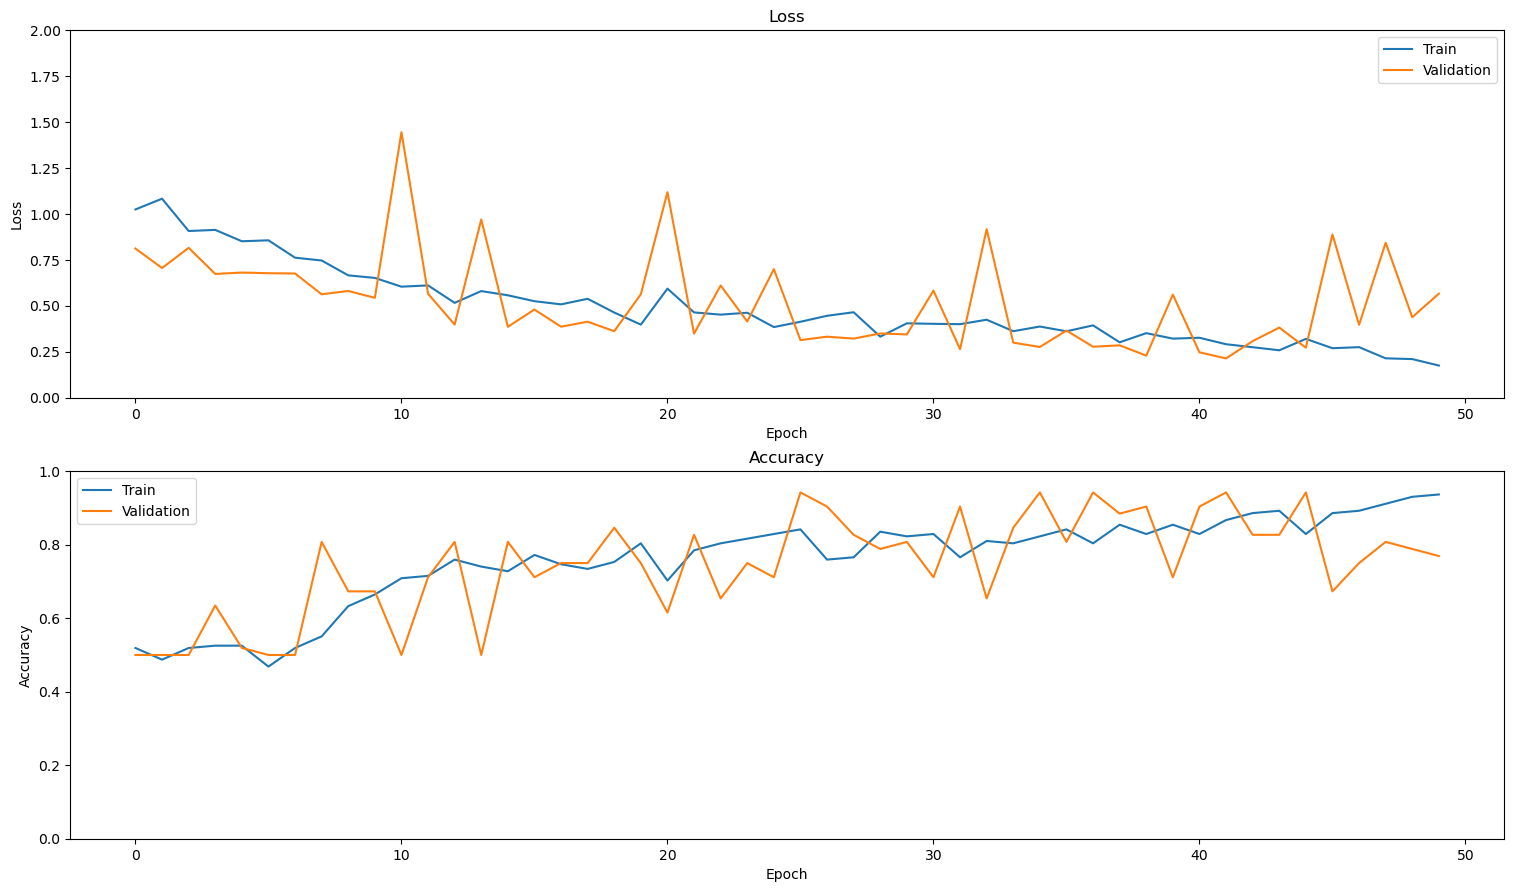

In [28]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [29]:
model.evaluate(test_ds)

13/13 [==============================] - 16s 1s/step - loss: 0.5377 - accuracy: 0.8367


[0.537653923034668, 0.8367347121238708]

In [30]:


def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


def frames_from_video_file_1(video_path, n_frames, output_size = (224,224), frame_step = 5):

  # Read each video frame by frame
  result = []
  opt_result = []
  src = cv2.VideoCapture(str(video_path))  
  #print('test')
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  temp_ret = None
  temp_frame = None
  for _ in range(frame_step):
    temp_rate, temp_frame = src.read()
  out = temp_frame - frame

  opt_result.append(format_frames(out, output_size))

  result.append(format_frames(frame, output_size))

  for _ in range(n_frames-1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      #cv2.im_write('test.png', frame)
      frame = format_frames(frame, output_size)
      out = frame - result[-1]
      opt_result.append(out)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
      opt_result.append(np.zeros_like(opt_result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]
  opt_result = np.array(opt_result)[..., [2, 1, 0]]
  return result, opt_result

class FrameGenerator_1:
  def __init__(self, path, n_frames, training = False, is_optics = False):

    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))
    self.is_optics = is_optics

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    #print(video_paths)
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    #print(classes)
    pairs = list(zip(video_paths, classes))
    #print(pairs)
    if self.training:
      random.shuffle(pairs)
  
    for path, name in pairs:
      optical_frames, video_frames = frames_from_video_file_1(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      if self.is_optics:
        yield optical_frames, label
      else:
        yield video_frames, label

In [31]:
n_frames = 25
batch_size = 4

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_os = tf.data.Dataset.from_generator(FrameGenerator_1(train_obj, n_frames, training=True, is_optics = True),
                                           output_signature = output_signature)


# Batch the data
train_os = train_os.batch(batch_size)

val_os = tf.data.Dataset.from_generator(FrameGenerator_1(valid_obj, n_frames, is_optics = True), output_signature = output_signature)
val_os = val_os.batch(batch_size)

test_os = tf.data.Dataset.from_generator(FrameGenerator_1(test_obj, n_frames, is_optics = True),
                                         output_signature = output_signature)

test_os = test_os.batch(batch_size)

In [104]:
input_shape = (None, 25, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input
#x = data_augmentation(input)

x = Conv2Plus1D(filters=32, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 1
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 2
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 3
x = add_residual_block(x, 128, (3, 3, 3))
#x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
#x = add_residual_block(x, 128, (3, 3, 3))



x = layers.GlobalAveragePooling3D()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(2)(x)

model2 = keras.Model(input, x)

In [105]:
frames, label = next(iter(train_os))
model2.build(frames)

In [106]:
keras_callbacks_1   = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights = True),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


In [107]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [108]:
history_1 = model2.fit(x = train_os,
                    epochs = 50, 
                    validation_data = val_os, callbacks = [keras_callbacks_1])

Epoch 1/50
40/40 [==============================] - 85s 2s/step - loss: 0.8184 - accuracy: 0.5570 - val_loss: 0.6552 - val_accuracy: 0.6154
Epoch 2/50
40/40 [==============================] - 81s 2s/step - loss: 0.8313 - accuracy: 0.5570 - val_loss: 0.6364 - val_accuracy: 0.6731
Epoch 3/50
40/40 [==============================] - 68s 2s/step - loss: 0.7593 - accuracy: 0.5823 - val_loss: 1.0075 - val_accuracy: 0.5000
Epoch 4/50
40/40 [==============================] - 82s 2s/step - loss: 0.6123 - accuracy: 0.6646 - val_loss: 0.4708 - val_accuracy: 0.8269
Epoch 5/50
40/40 [==============================] - 68s 2s/step - loss: 0.6441 - accuracy: 0.6203 - val_loss: 0.6046 - val_accuracy: 0.6731
Epoch 6/50
40/40 [==============================] - 68s 2s/step - loss: 0.6434 - accuracy: 0.6519 - val_loss: 0.7153 - val_accuracy: 0.6346
Epoch 7/50
40/40 [==============================] - 68s 2s/step - loss: 0.5534 - accuracy: 0.7468 - val_loss: 1.3440 - val_accuracy: 0.5000
Epoch 8/50
40/40 [==

In [37]:
#model2.save('my_model2')

In [102]:
new_model = tf.keras.models.load_model('/kaggle/working/my_model2')

In [117]:
model2.evaluate(test_os)

13/13 [==============================] - 14s 1s/step - loss: 0.4080 - accuracy: 0.7347


[0.4079625606536865, 0.7346938848495483]

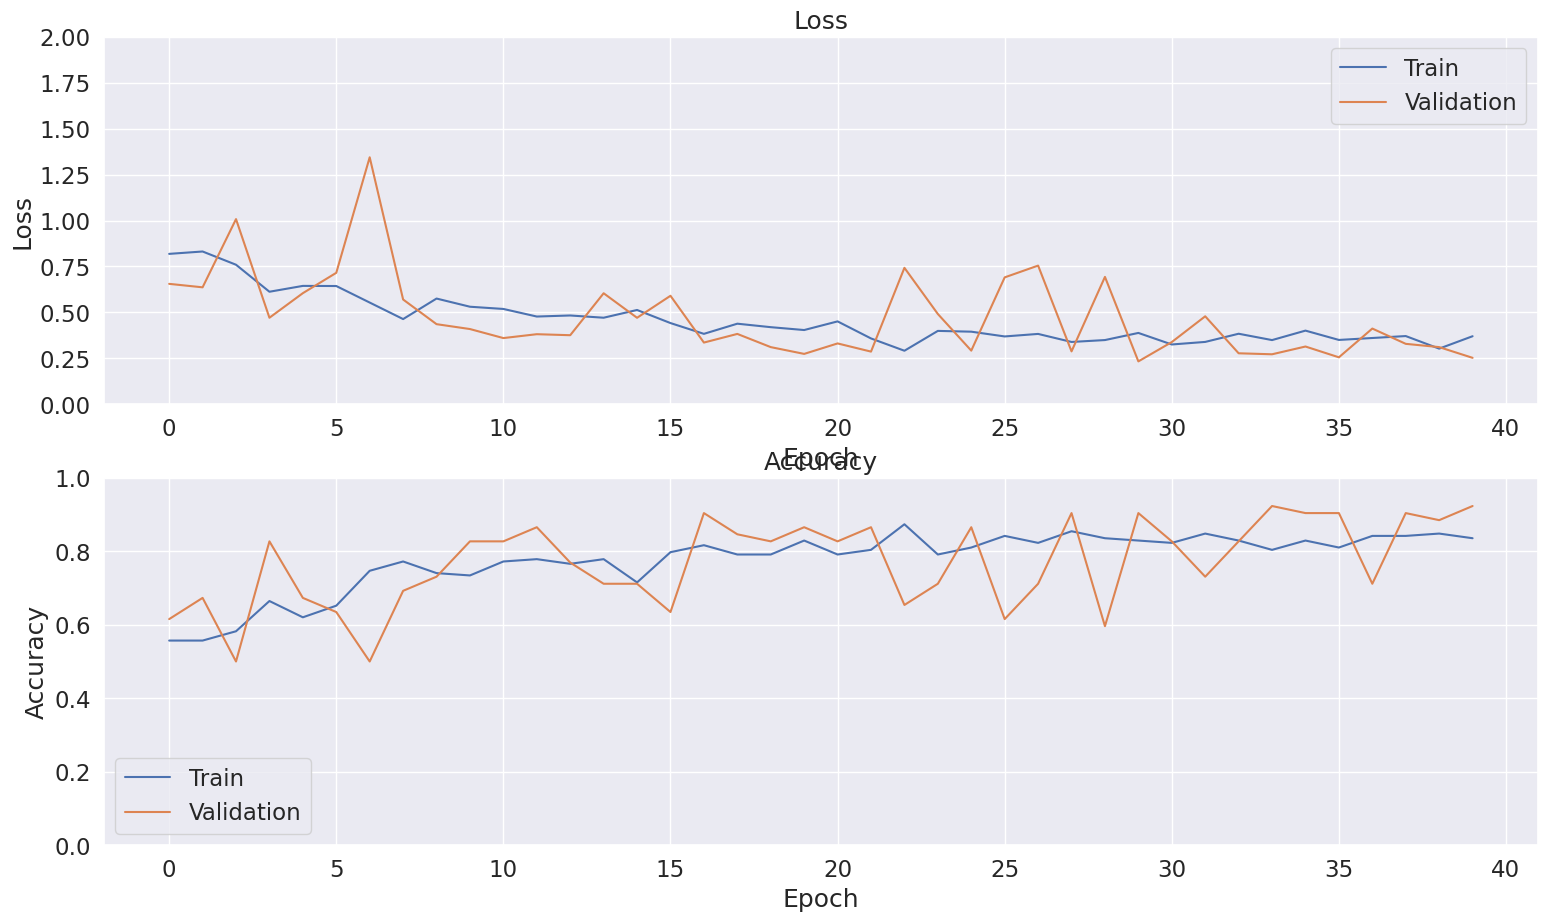

In [111]:
def plot_history(history_1):

  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history_1.history['loss'], label = 'train')
  ax1.plot(history_1.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history_1.history['loss'] + history_1.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history_1.history['accuracy'],  label = 'train')
  ax2.plot(history_1.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history_1)

In [39]:
##################         concatenate          ###################     concatenate    ###################

In [41]:
input_shape = (None, 25, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

def models():

    inputs = x
    
    
    
    combined = tf.keras.layers.Concatenate()([model(inputs), model2(inputs)])
    
    combined = tf.keras.layers.Dense(512, activation='relu')(combined)
    combined = tf.keras.layers.Dense(64, activation='relu')(combined)
    combined = tf.keras.layers.Dense(2, activation='softmax')(combined)

    M = tf.keras.Model(inputs=inputs, outputs=combined)
    M.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  metrics = ['accuracy'])
    
    return M

fused_model = models()
fused_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 model (Functional)             (None, 2)            2026946     ['input_3[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 2)            642402      ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 4)            0           ['model[0][0]',            

In [42]:
keras_callbacks_2 = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights = True),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [43]:
history_2 = fused_model.fit(x = train_os,
                    epochs = 50, 
                    validation_data = val_os, callbacks = [keras_callbacks_2])

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 125s 3s/step - loss: 0.5263 - accuracy: 0.7342 - val_loss: 0.3028 - val_accuracy: 0.9038
Epoch 2/50
40/40 [==============================] - 115s 3s/step - loss: 0.3539 - accuracy: 0.8418 - val_loss: 0.2552 - val_accuracy: 0.9231
Epoch 3/50
40/40 [==============================] - 114s 3s/step - loss: 0.2308 - accuracy: 0.9304 - val_loss: 0.1930 - val_accuracy: 0.9423
Epoch 4/50
40/40 [==============================] - 85s 2s/step - loss: 0.3170 - accuracy: 0.8671 - val_loss: 0.4969 - val_accuracy: 0.7692
Epoch 5/50
40/40 [==============================] - 86s 2s/step - loss: 0.2523 - accuracy: 0.8987 - val_loss: 0.2608 - val_accuracy: 0.8846
Epoch 6/50
40/40 [==============================] - 116s 3s/step - loss: 0.2190 - accuracy: 0.9051 - val_loss: 0.1863 - val_accuracy: 0.9231
Epoch 7/50
40/40 [==============================] - 87s 2s/step - loss: 0.2188 - accuracy: 0.9304 - val_loss: 0.2643 - val_accuracy: 0.8269
Epoch 8/50
40/40 [=========

In [44]:
fused_model.save('final_model')

In [110]:
#!zip -r final_model.zip /kaggle/working

In [ ]:
#model.save('Latest_Model')

In [46]:
fused_model.evaluate(test_ds)

13/13 [==============================] - 16s 1s/step - loss: 0.1301 - accuracy: 0.9388


[0.13014546036720276, 0.9387755393981934]

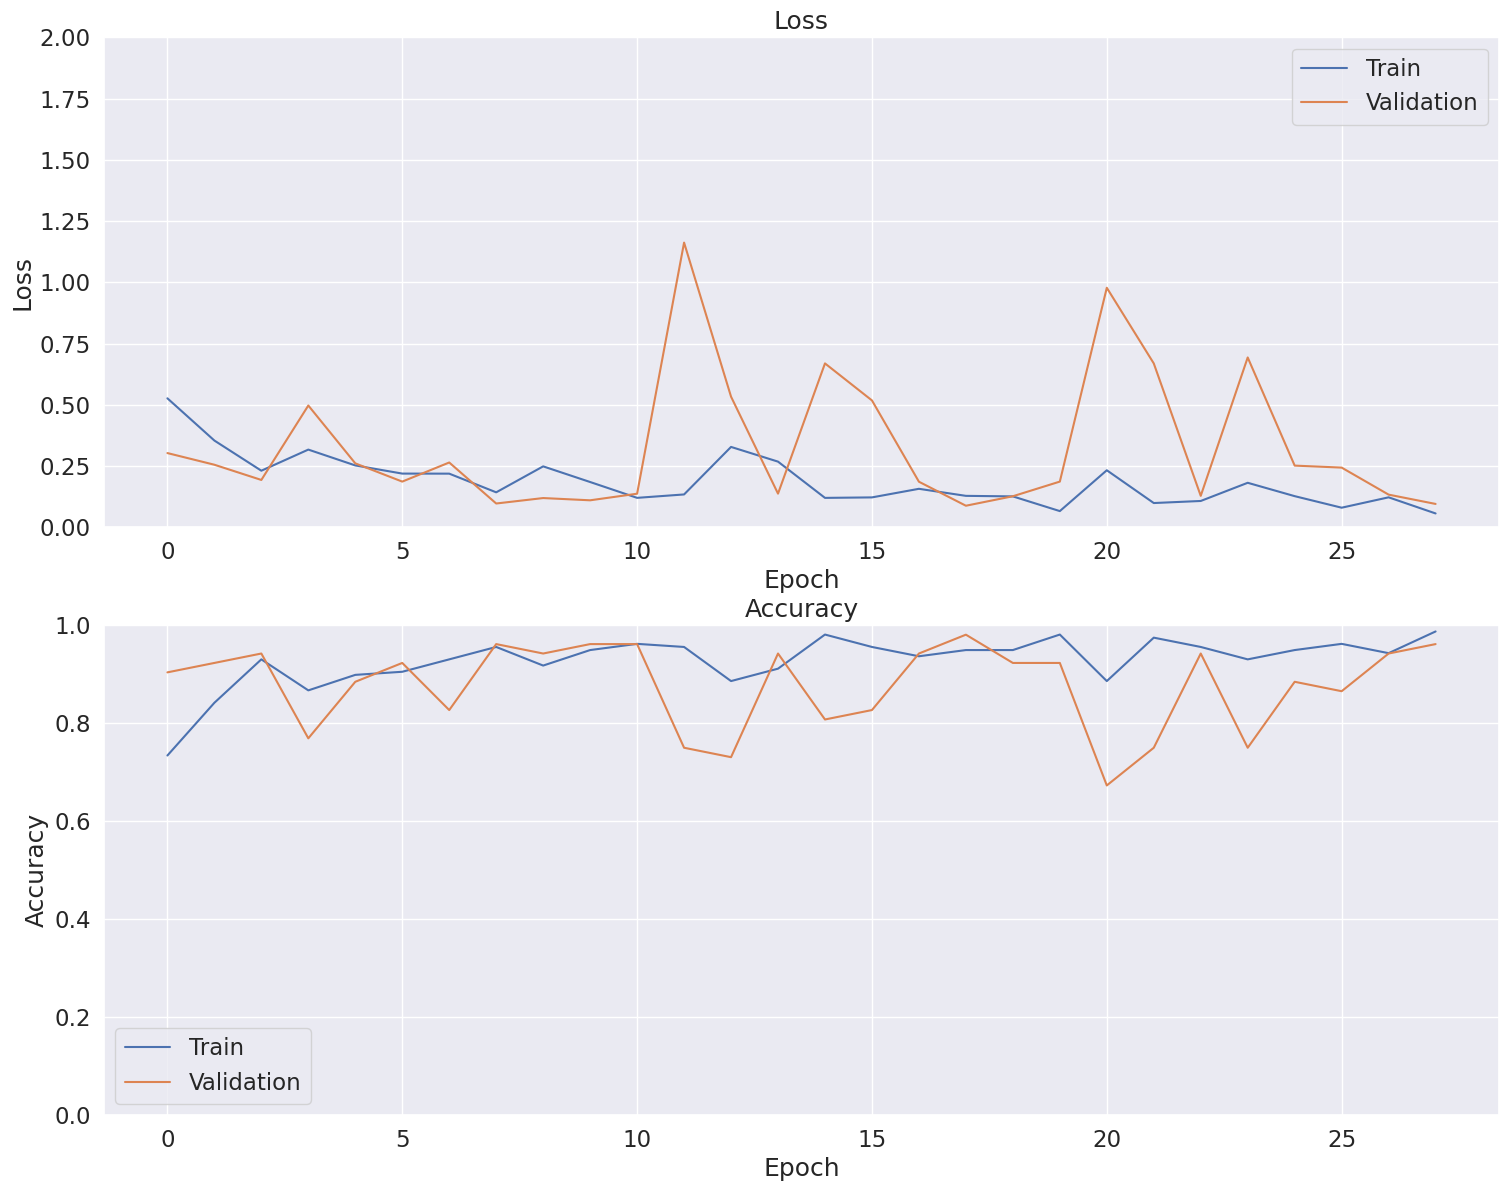

In [113]:
def plot_history(history):

  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18, 14)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history_2)

In [49]:
def get_actual_predicted_labels(dataset): 

  actual = [labels for _, labels in dataset.unbatch()]
  predicted = fused_model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [50]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(7, 7)})
  sns.set(font_scale=1.5)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [52]:
fg = FrameGenerator(train_obj, n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
# actual, predicted = get_actual_predicted_labels(train_ds)
# plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 [==============================] - 15s 1s/step


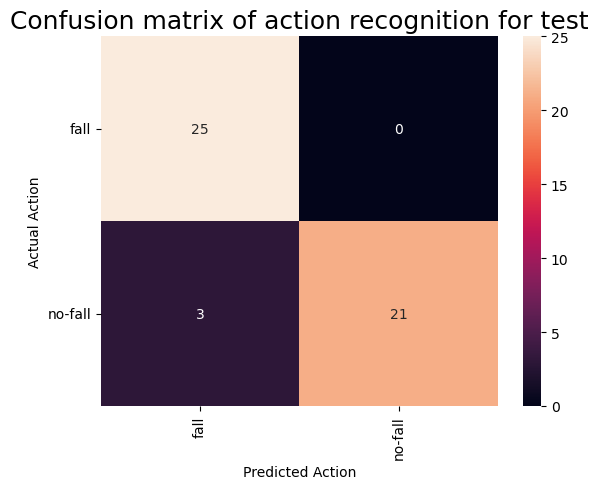

In [53]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def get_actual_predicted_labels(dataset): 
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = fused_model.predict(dataset)
  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [58]:
def see_frames(video):
  idxs = np.floor(np.random.rand(2, 3) * 24).astype(int)
  fig, axs = plt.subplots(2, 3)

  for i in range(2):
    for j in range(3):
      axs[i,j].grid(False)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      idx = idxs[i][j]
      axs[i, j].set_title('frame ' + str(idx))
      fr = (video[idx] * 255).astype(int)
      axs[i, j].imshow(fr)

In [73]:

def get_predictions(ds, model):
  c1 = 0
  c2 = 0
  classes = ['fall', 'no-fall']
  test_it = ds.as_numpy_iterator()
  for i in range(13):
    tbatch = test_it.next()
    for j in range(tbatch[0].shape[0]):
      video = tbatch[0][j]
      label = tbatch[1][j]
      video = np.reshape(video, (1,) + video.shape)
      res = classes[np.argmax(model.predict(video))]
      if (res == 'fall'):
        c1 +=1
      else:
        c2 +=1
      print("Actual : " + classes[label] + "," + "Predicted : " + res)
  print("Total Predicted Fall:", c1)
  print("Total Predicted Non-Fall:", c2)   

In [74]:

get_predictions(test_ds, fused_model)

1/1 [==============================] - 0s 87ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 85ms/step
Actual : no-fall,Predicted : fall
1/1 [==============================] - 0s 82ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 81ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 83ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 82ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 83ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 81ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 84ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 83ms/step
Actual : no-fall,Predicted : no-fall
1/1 [==============================] - 0s 82ms/step
Actual : no-fall,Predicted : fall
1/1 [======================

In [61]:
def predict_video_result(video_path, model):
  classes = ['fall', 'no-fall']
  vid_frames = frames_from_video_file(video_path, n_frames=25)
  vid = np.reshape(vid_frames, (1,) + vid_frames.shape)
  res = classes[np.argmax(model.predict(vid))]
  print("Predicted Label: " + res)
  see_frames(vid_frames)

1/1 [==============================] - 0s 93ms/step
Predicted Label: fall


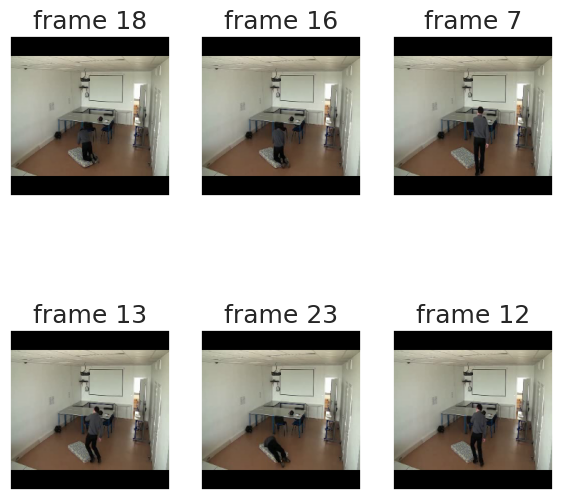

In [124]:
predict_video_result('/kaggle/input/thesis-dataset/Lei2-fall/test/fall/video_0.avi', fused_model)

In [123]:
#

The precision and recall values for each class can also be calculated using a confusion matrix.

In [54]:
def calculate_classification_metrics(y_actual, y_pred, labels):

  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [55]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [56]:
precision

{'fall': 0.8928571428571429, 'no-fall': 1.0}

In [57]:
recall

{'fall': 1.0, 'no-fall': 0.875}